In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Y3.S1 FDM

/content/drive/MyDrive/Y3.S1 FDM


In [5]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

In [6]:
# Load the dataset
data = pd.read_csv("student mental health_1.csv")

In [7]:
# Data Preprocessing

# Feature Engineering

# 1. Create Age Groups based on Age
data['Age_Group'] = pd.cut(data['Age'], bins=[0, 19, 29, 39, float('inf')],
                          labels=['Teen', 'Young Adult', 'Adult', 'Senior'])

# 2. Categorize Credit Load into Low, Medium, and High
data['Credit_Load_Category'] = pd.cut(data['Semester_Credit_Load'], bins=[15, 20, 25, float('inf')],
                                      labels=['Low', 'Medium', 'High'])

# 3. Categorize CGPA into Low, Medium, High, and Excellent
data['CGPA_Category'] = pd.cut(data['CGPA'], bins=[0, 3, 3.5, 4, float('inf')],
                              labels=['Low', 'Medium', 'High', 'Excellent'])

# Handle Missing Data

# Handle missing values in numerical columns by filling with the mean
numerical_columns = ['Age', 'CGPA', 'Stress_Level', 'Depression_Score', 'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load']
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())

# Handle missing values in categorical columns by filling with the mode (most frequent value)
categorical_columns = [
    'Course', 'Gender', 'Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support',
    'Relationship_Status', 'Substance_Use', 'Counseling_Service_Use', 'Family_History',
    'Chronic_Illness', 'Extracurricular_Involvement', 'Residence_Type',
    'Age_Group', 'Credit_Load_Category', 'CGPA_Category']

for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Encode Categorical Data

# Use LabelEncoder to convert categorical columns into numerical values
label_encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Remove duplicate records
data = data.drop_duplicates()

# Handle Outliers

# Calculate summary statistics for the dataset
summary = data.describe()
Q1 = summary.loc['25%']
Q3 = summary.loc['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and remove outliers using the IQR method
is_outlier = ((data < lower_bound) | (data > upper_bound)).any(axis=1)
data = data[~is_outlier]

# Drop the "Semester_Credit_Load" column
data = data.drop(columns=['Semester_Credit_Load'])
#data = data.drop(columns=['Age'])

# Map Stress_Level to binary values

# Map stress level values to binary categories
stress_level_mapping = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3}
data['Stress_Level'] = data['Stress_Level'].replace(stress_level_mapping)

# Split the data into features (X) and the target (y)
X = data.drop(columns=['Stress_Level'])
y = data['Stress_Level']

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Find Feature Dependencies
# Calculate Mutual Information for Feature Selection

# Calculate mutual information between features and the target variable
mutual_info = mutual_info_classif(X, y)
mutual_info_series = pd.Series(mutual_info, index=X.columns)
mutual_info_series.sort_values(ascending=False, inplace=True)
print(mutual_info_series)

Depression_Score               0.214983
Anxiety_Score                  0.024010
Course                         0.018698
Gender                         0.017046
Substance_Use                  0.015105
Age_Group                      0.008280
CGPA_Category                  0.008213
Physical_Activity              0.007342
Diet_Quality                   0.006173
Age                            0.005637
Social_Support                 0.005490
Family_History                 0.004839
Sleep_Quality                  0.003844
Extracurricular_Involvement    0.001913
Residence_Type                 0.000757
Counseling_Service_Use         0.000000
Chronic_Illness                0.000000
Financial_Stress               0.000000
CGPA                           0.000000
Credit_Load_Category           0.000000
Relationship_Status            0.000000
dtype: float64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

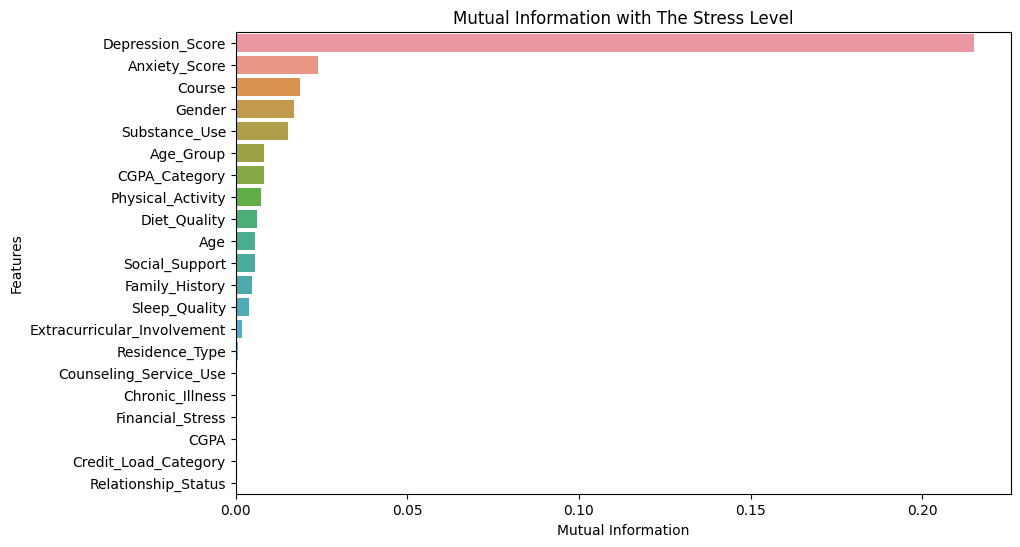

In [10]:
# Create a bar plot for mutual information
plt.figure(figsize=(10, 6))
sns.barplot(x=mutual_info_series.values, y=mutual_info_series.index, orient="h")
plt.title("Mutual Information with The Stress Level")
plt.xlabel("Mutual Information")
plt.ylabel("Features")
plt.show()

# Random Forest Classifier Model

In [11]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV is commented out because the best parameters are already known
# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

# Manually set the best hyperparameters based on the grid search results
best_params = {'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

# Train a random forest classifier model with the best hyperparameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [12]:
print("Model Accuracy:", accuracy)
#print("Best Hyperparameters:", best_params)
print("Classification Report:\n", report)

Model Accuracy: 0.8357348703170029
Classification Report:
               precision    recall  f1-score   support

           1       0.88      0.83      0.85       593
           2       0.79      0.84      0.82       448

    accuracy                           0.84      1041
   macro avg       0.83      0.84      0.83      1041
weighted avg       0.84      0.84      0.84      1041



Gradient Boosting (XGBoost):

In [16]:
import xgboost as xgb

# Define hyperparameters
params = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'random_state': 42
}

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print("XGBoost Model Results:")
print(f"Accuracy: {accuracy_xgb:.2f}")
print("Classification Report:\n", report_xgb)

ValueError: ignored

Support Vector Machine (SVM):

In [17]:
from sklearn.svm import SVC

# Define hyperparameters
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

print("SVM Model Results:")
print(f"Accuracy: {accuracy_svm:.2f}")
print("Classification Report:\n", report_svm)

SVM Model Results:
Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.81      0.84       593
           2       0.77      0.83      0.80       448

    accuracy                           0.82      1041
   macro avg       0.81      0.82      0.82      1041
weighted avg       0.82      0.82      0.82      1041



Neural Network (Multi-layer Perceptron - MLP):

In [18]:
from sklearn.neural_network import MLPClassifier

# Define hyperparameters
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42)

# Train the MLP model
mlp_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_mlp = mlp_model.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
report_mlp = classification_report(y_test, y_pred_mlp)

print("MLP Model Results:")
print(f"Accuracy: {accuracy_mlp:.2f}")
print("Classification Report:\n", report_mlp)

MLP Model Results:
Accuracy: 0.80
Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.76      0.81       593
           2       0.73      0.84      0.78       448

    accuracy                           0.80      1041
   macro avg       0.80      0.80      0.80      1041
weighted avg       0.81      0.80      0.80      1041



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
